100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.16it/s]


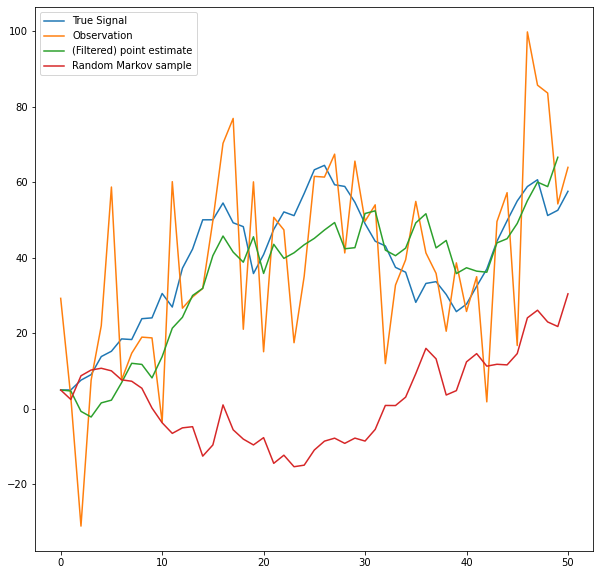

In [31]:
#Simple particle filtering experiment for linear state space model with normal noise (Kalman case)

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete
from tqdm import tqdm

y_sigma = 20

def pnorm(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*math.pi)))*np.exp((-1/2)*(((x-mu)/sigma)**2))

def mdynamics(x_t, x_t1):
    return pnorm(x_t, x_t1, 1)

def ydynamics(y_t, x_t):
    #For non-normal experiments
    #Gamma k=8, theta = np.sqrt(np.abs(x_t))
    condvar = np.sqrt(np.abs(x_t))
    return (1/(math.factorial(7)*(condvar)**8))*(y_t**7)*np.exp(-(y_t/condvar))

def ydynamics2(y_t, x_t, y_sigma):
    return pnorm(y_t, x_t, 20)

def generate_x(n = 50, init = 5):
    xvals = [init]
    for i in range(n):
        xvals.append(np.random.normal(xvals[i]+1,5))
    return xvals

def generate_y(xvals, y_sigma):
    yvals = []
    for val in xvals:
        yvals.append(np.random.normal(val, 20))
    return yvals

xvals = generate_x()
yvals = generate_y(xvals, y_sigma)

fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.plot(xvals, label = 'True Signal')
ax.plot(yvals, label = 'Observation')



#Sequential Monte Carlo starts here, draw N sequences of length T = 50 with resampling step to prevent particle degeneracy
N = 1000
xarr = []

for t in tqdm(range(50)):
    weights = []
    xarr_new = []
    if(t == 0):
        #Initialization Step
        for i in range(N):
            xarr.append([5])
    else:
        for i in range(N):
            xarr[i].append(np.random.normal(xarr[i][-1] + 1,5))
            weights.append(ydynamics2(yvals[t], xarr[i][-1], y_sigma))

        wsum = np.sum(weights)
        
        for i in range(N):
            weights[i] = weights[i]/wsum

        distrib = rv_discrete(values = (range(N), weights))

        for i in range(N):
            xarr_new.append(xarr[distrib.rvs()].copy())
        xarr = xarr_new

#Plot results (uniformly picking a random point estimate, ignoring the fact that an estimate of the whole posterior is available)
ax.plot(xarr[np.argmax(weights)], label =  '(Filtered) point estimate')
#Comparing it to a random sequence generated by the same underlying model
ax.plot(generate_x(), label = 'Random Markov sample')
ax.legend()